In [1]:
# Load Library
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import sklearn
import libsvm
from libsvm.svmutil import *
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score


%matplotlib inline
random.seed(1)

In [4]:
# Load Train Data
Data = pd.read_csv("/Users/yuchenlu/Desktop/671_Kaggle_Project/Data/Raw/train.csv")
Data['Neighbourhood'] = Data['Neighbourhood'].astype(str)
Y = Data['Decision']
X = Data.drop(['Decision'], axis=1)
# Load Test Data
Test = pd.read_csv("/Users/yuchenlu/Desktop/671_Kaggle_Project/Data/Raw/test.csv")
Test['Neighbourhood'] = Test['Neighbourhood'].astype(str)

In [5]:
def Encode(airbnb):
    for column in airbnb.columns[airbnb.columns.isin(['Room_type', 'Month','Neighbourhood'])]:
        airbnb[column] = airbnb[column].factorize()[0]
    return airbnb

X_data = Encode(X.copy())
Test_data = Encode(Test.copy())

In [6]:
# Split Data: 20% Test, 80% Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,Y, test_size=0.2, random_state= 1)

# Base Model

[[206 342]
 [ 89 858]]


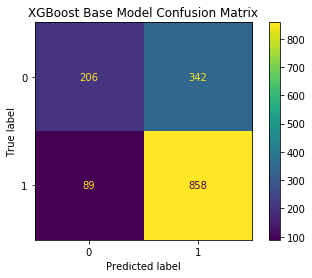

              precision    recall  f1-score   support

           0       0.70      0.38      0.49       548
           1       0.71      0.91      0.80       947

    accuracy                           0.71      1495
   macro avg       0.71      0.64      0.64      1495
weighted avg       0.71      0.71      0.69      1495



TypeError: accuracy_score() got an unexpected keyword argument 'average'

In [9]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report,plot_confusion_matrix
import xgboost as xgb

clf=xgb.XGBClassifier()
    
evaluation = [( X_train, y_train), ( X_test, y_test)]
    
clf.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=False)


pred = clf.predict(X_test)
print(confusion_matrix(y_test,  pred>0.5))
plot_confusion_matrix(clf, X_test, y_test)  
plt.title("XGBoost Base Model Confusion Matrix")
plt.show()
print(classification_report(y_test,  pred>0.5))
print('the f1 score is',accuracy_score(y_test, pred>0.5, average='weighted'))

We have an f2 score of 0.6854305736535787. Based on the confusion matrix, we have a large false positive rate of 62.41%, which is worse then random guessing. We have a low false negative rate of 9.40%, a good accuracy for all positive decisions. We bieleve the current threshold has maximize the FP rate. Therefore, I will We first optimize threshold through looking at the ROC Curve and AUC.

## Optimize Threshold

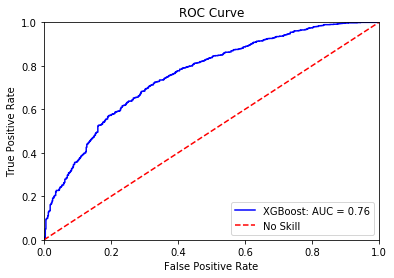

In [17]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'XGBoost: AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label = "No Skill")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [18]:
threshold = np.arange(0.0, 1.0, 0.01)
F_score = []

def best_threshold(threshold):
    ypred = (clf.predict_proba(X_test))
    p = [el[1] for el in ypred]
    prediction = pd.DataFrame (p, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > threshold else 0)
    f1 = f1_score(y_test, prediction, average='weighted')
    F_score.append(f1)
for i in threshold:
    best_threshold(i)

In [19]:
threshold_prediction = pd.DataFrame({'threshold': threshold, 'F_score': F_score}, 
                                    columns=['threshold', 'F_score'])

threshold_prediction[threshold_prediction['F_score']==threshold_prediction['F_score'].max()]

,threshold,F_score
60,0.6,0.71078


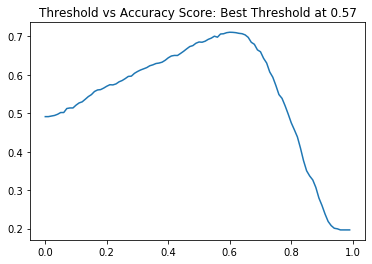

In [24]:
# Plot Best Threshold
sns.lineplot(x = threshold, y = F_score, data = threshold_prediction) 
plt.title("Threshold vs Accuracy Score: Best Threshold at 0.57")
plt.show()

In [25]:
ypred = (clf.predict_proba(X_test))
p = [el[1] for el in ypred]
prediction = pd.DataFrame (p, columns = ['Decision'])
prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.6 else 0)
print(confusion_matrix(y_test, prediction))
print('the accuracy score is',accuracy_score(y_test, prediction))

[[315 233]
 [196 751]]
the accuracy score is 0.7130434782608696


In [26]:
# Tune Prediciton Threshold
def Predict_XGBoost(clf,X_test):
    ypred = clf.predict_proba(X_test)
    p = [el[1] for el in ypred]
    prediction = pd.DataFrame (p, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.6 else 0)
    return(prediction)

In [31]:
pred = Predict_XGBoost(clf,Test_data)
submission = pd.read_csv("/Users/yuchenlu/Desktop/671_Kaggle_Project/Submission/sample_submission.csv")
submission['Decision'] = pred
submission['Decision'].value_counts()
# pd.DataFrame(submission).to_csv("XGBoost_Optimized_Submission.csv",index=False)

1    1638
0     802
Name: Decision, dtype: int64

## Tuning: Find the Best Objective

Because Gradient Descent tries to optimize model performance by minimizing the defined loss function, we will try to find the best objective for the airbnb Dataset. Because the prediction goal is binary, the available objective are
* binary:logistic : logistic regression for binary classification, output probability
* binary:logitraw: logistic regression for binary classification, output score before logistic transformation
* binary:hinge : hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities

In [32]:
objective = ["binary:logistic","binary:logitraw","binary:hinge"]
F_score = []
for el in objective: 
    clf = xgb.XGBClassifier(booster = "gbtree", objective=el)  
    clf.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="mae",
        early_stopping_rounds=10,verbose=False)
    prediction = Predict_XGBoost(clf,X_test)
    f1 = f1_score(y_test, prediction, average='weighted')
    F_score.append(f1)

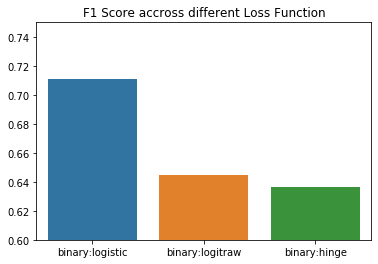

In [33]:
objective_prediction = pd.DataFrame({'objective': objective, 'F_score': F_score}, 
                                    columns=['objective', 'F_score'])
# objective_prediction
sns.barplot(x = objective, y = F_score, data = objective_prediction) 
plt.ylim(0.6, 0.75)
plt.title("F1 Score accross different Loss Function")
plt.show()

We observe highest accuracy score with Binary: **Logistic Objective** at 0.731083.

In [34]:
# Learning Rate
eta = np.arange(0.0, 1.0, 0.01)
F_score = []
for i in eta: 
    clf = xgb.XGBClassifier(booster = "gbtree",objective = 'binary:logistic', 
                            learning_rate = i) 
    clf.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=False)
    prediction = Predict_XGBoost(clf,X_test)
    f1 = f1_score(y_test, prediction, average='weighted')
    F_score.append(f1)

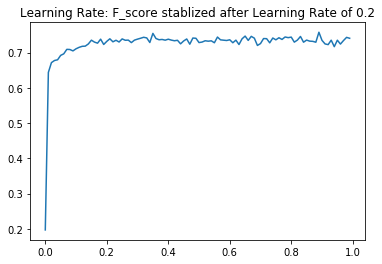

In [35]:
ETA_prediction = pd.DataFrame({'eta': eta, 'F_score': F_score}, 
                                    columns=['eta', 'F_score'])
# objective_prediction
sns.lineplot(x = eta, y = F_score, data = ETA_prediction) 
# plt.ylim(0.7, 0.75)
plt.title("Learning Rate: F_score stablized after Learning Rate of 0.2")
plt.show()

# Continue Optimization with Logistic Objective (GridSearchCV)
https://hyperopt.github.io/hyperopt/?source=post_page

In [36]:
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier()   #subsample=0.5, colsample_bytree=0.5, seed=0

cv_params = {'max_depth': [1,2,3,4,5,6], 
             'min_child_weight': [1,2,3,4],
             'n_estimators':[10,20,30,40,50]}

fix_params = {"booster":"gbtree",
              'learning_rate': 0.2,
              'objective':'binary:logistic'}  

clf = GridSearchCV(xgb.XGBClassifier(**fix_params),
                   cv_params, scoring = 'f1_weighted', cv = 5)

In [37]:
# Fit grid search
best_model = clf.fit(X_train, y_train)
# Best parameter 
print('Best parameter:', best_model.best_params_)

Best parameter: {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 50}


For Max_Depth and Min_child_weight we found the best parameter: **{'max_depth': 6, 'min_child_weight': 2, n_estimatro = 50}**


In [38]:
clf = xgb.XGBClassifier(booster = "gbtree",objective = 'binary:logistic', 
                        max_depth = 6, learning_rate=0.45, n_estimators=50,
                        min_child_weight = 2) 
clf.fit(X_train, y_train, eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=100,verbose=False)
prediction = Predict_XGBoost(clf,X_test)
print(f1_score(y_test, prediction, average='weighted'))
print(accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))

0.75786059267917
0.757190635451505
[[374 174]
 [189 758]]


In [40]:
pred = clf.predict(Test_data)
submission = pd.read_csv("/Users/yuchenlu/Desktop/671_Kaggle_Project/Submission/sample_submission.csv")
submission['Decision'] = pred
submission['Decision'].value_counts()
pd.DataFrame(submission).to_csv("XGBoost_Optimized_Submission.csv",index=False)

In [41]:
submission = pd.read_csv("XGBoost_Optimized_Submission.csv")
submission['Decision'].value_counts()

1    1717
0     723
Name: Decision, dtype: int64